# Projeto de Teste A/B

**Objetivos da Análise:**

O estudo tem como objetivo avaliar o impacto da introdução de uma recomendação do sistema melhorada em uma loja online internacional. Os principais objetivos incluem medir o aumento na conversão nas etapas do funil de compra, verificar a significância estatística das diferenças entre grupos A e B, entender o comportamento dos novos usuários da região da União Europeia e fornecer recomendações para otimização, se necessário. O foco está na melhoria da eficácia do sistema de recomendação e na geração de insights para decisões futuras.

# Inicialização

Vamos começar com as bibliotecas necessárias relevantes para nossa análise

In [ ]:
# Carregando bibliotecas
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
import warnings

# Descrição os dados

`ab_project_marketing_events_us.csv` — o calendário de eventos de marketing para 2020

**O conjunto de dados inclui os seguintes campos**:

- `name` — do nome dos eventos de marketing
- `regions` — das regiões onde a campanha será realizada
- `start_dt` — de data de início da campanha
- `finish_dt` — da data de término da campanha

----------------------------------------------------------------------------------------------------------------------
`final_ab_new_users_upd_us.csv` — todos os usuários que se cadastraram na loja online de 7 de dezembro a 21, de 2020

**O conjunto de dados inclui os seguintes campos**:

- `user_id`
- `first_date` — da data de cadastro
- `region`
- `device` — do dispositivo usado para o cadastro

----------------------------------------------------------------------------------------------------------------------
`final_ab_events_upd_us.csv` — todos os eventos dos novos usuários dentro do período de 7 de dezembro, de 2020 até 1 de janeiro, de 2021

**O conjunto de dados inclui os seguintes campos**:

- `user_id`
- `event_dt` — da data e hora do evento
- `event_name` — do nome da fonte do evento
- `details` — dos dados adicionais sobre o evento (por exemplo, o total do pedido em USD para eventos `purchase`)
----------------------------------------------------------------------------------------------------------------------
`final_ab_participants_upd_us.csv` — tabela contendo os participantes do teste

**O conjunto de dados inclui os seguintes campos**:

- `user_id`
- `ab_test` — nome do teste
- `group` — o grupo de teste ao qual o usuário pertencia

# Carregando os dados

Vamos armazenar os dados em uma variável específica e, em seguida, otimizá-los para a análise, certificando-nos de que cada coluna contenha o tipo correto de dados.

In [ ]:
# Carregando os dados
project_marketing = pd.read_csv('/datasets/ab_project_marketing_events_us.csv')
users = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv')
events = pd.read_csv('/datasets/final_ab_events_upd_us.csv')
participants = pd.read_csv('/datasets/final_ab_participants_upd_us.csv')

## Explorando os dados
### Explorando dataframe `project_marketing`

In [ ]:
# Analisando informações detalhadas sobre os dataframes
project_marketing.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 4.0 KB


Observando o DataFrame `project_marketing`, notamos que todas as colunas têm o tipo de dado `object`, o que é comum para strings. No entanto, considerando as informações presentes, pode ser benéfico converter as colunas de datas (`start_dt` e `finish_dt`) para o tipo de data. Isso facilitará a manipulação e análise de datas.

In [ ]:
# Converter as colunas de data para o tipo de data
project_marketing['start_dt'] = pd.to_datetime(project_marketing['start_dt'])
project_marketing['finish_dt'] = pd.to_datetime(project_marketing['finish_dt'])

In [ ]:
# Verificar os tipos de dados após a conversão
project_marketing.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 2.4 KB


In [ ]:
# Verificando dados ausentes
project_marketing.isna().sum()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

In [ ]:
# Verificando dados duplicados
project_marketing.duplicated().sum()

0

In [ ]:
# Analisando fatia do dataframe
project_marketing.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


Ajustamos os tipos de dados, conseguimos otimizar o dataframe reduzindo o espaço usado de memória e verificamos que não há dados ausentes ou duplicados.

### Explorando dataframe `events`

In [ ]:
events.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 89.9 MB


No DataFrame `events`, observamos que a coluna `event_dt` contém datas e horas de eventos. Para facilitar análises de tempo e cálculos relacionados, é aconselhável converter a coluna `event_dt` para o tipo de data e hora. O restante das colunas parece estar no formato apropriado para seus tipos de dados.

In [ ]:
# Converter a coluna de data e hora para o tipo de data
events['event_dt'] = pd.to_datetime(events['event_dt'])

In [ ]:
# Verificar os tipos de dados após a conversão
events.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     60314 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 62.4 MB


In [ ]:
# Verficando dados ausentes
events.isna().sum()

user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64

In [ ]:
# Analisando os dados Nan
missing_details = events[events['details'].isnull()]
missing_details

,user_id,event_dt,event_name,details
60314,2E1BF1D4C37EA01F,2020-12-07 09:05:47,product_cart,NaN
60315,50734A22C0C63768,2020-12-07 13:24:03,product_cart,NaN
60316,5EB159DA9DC94DBA,2020-12-07 22:54:02,product_cart,NaN
60317,084A22B980BA8169,2020-12-07 15:25:55,product_cart,NaN
60318,0FC21E6F8FAA8DEC,2020-12-07 06:56:27,product_cart,NaN
...,...,...,...,...
423756,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
423757,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
423758,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
423759,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


In [ ]:
# Verificando dados duplicados
events.duplicated().sum()

0

In [ ]:
# Analisando fatia do dataframe
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


Para lidar com os ausentes vamos:

1. Usar a função `pd.to_numeric` para converter os valores na coluna 'details' em números. Se um valor não puder ser convertido em um número, ele será tratado como NaN (não disponível).

2. Calcular a Mediana: Calculamos a mediana dos valores não nulos na coluna 'details'. A mediana é uma medida estatística que representa o valor do meio de um conjunto de dados ordenados. É uma escolha comum para tratar valores atípicos ou extremos, pois é menos sensível a eles do que a média.

3. Preenchimento de Valores Ausentes: Substituímos os valores NaN na coluna 'details' pela mediana calculada. Isso é feito usando o método `.fillna()`.

A razão para substituir os valores ausentes pela mediana é que a mediana é uma medida de tendência central robusta, o que significa que ela não é afetada por valores extremos. Isso torna a mediana uma escolha segura e adequada quando lidamos com dados que podem conter outliers ou valores não numéricos. A substituição permite que os dados permaneçam coerentes e prontos para análises subsequentes, como o cálculo de métricas ou a realização de testes estatísticos.

Em resumo, o código garante que a coluna 'details' seja composta por valores numéricos, tratando adequadamente os valores ausentes ou não numéricos, e preenchendo os valores ausentes com uma medida de tendência central adequada, como a mediana. Isso é importante para manter a qualidade dos dados e facilitar análises futuras.

In [ ]:
# Preenchendo valores ausentes
# Substituir os valores não numéricos (por exemplo, 'N/A') por NaN
events['details'] = pd.to_numeric(events['details'], errors='coerce')

In [ ]:
# Calcular a mediana dos valores na coluna 'details' e preencher os ausentes com a mediana
median_value = events['details'].median()
events['details'].fillna(median_value, inplace=True)

In [ ]:
# Verificando preenchimento
events.isna().sum()

user_id       0
event_dt      0
event_name    0
details       0
dtype: int64

### Explorando dataframe `users`

In [ ]:
users.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 14.7 MB


No DataFrame `users`, as colunas `user_id`, `first_date`, `region` e `device` têm o tipo de dado `object`, o que é comum para strings. No entanto, é importante observar que a coluna `first_date` representa a data de cadastro, e converter essa coluna para o tipo de data é uma prática recomendada para facilitar análises de tempo. Portanto, recomenda-se converter apenas a coluna `first_date` para o tipo de data.


In [ ]:
# Converter a coluna de data para o tipo de data
users['first_date'] = pd.to_datetime(users['first_date'])

In [ ]:
# Verificar os tipos de dados após a conversão
users.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 11.4 MB


In [ ]:
# Verificando dados ausentes
users.isna().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

In [ ]:
# Verificando dados duplicados
users.duplicated().sum()

0

Dessa forma convertemos os tipos de dados para mais apropriados e otimizamos o espaço na memória usado. Não encontramos dados ausentes ou duplicados nesse dataframe.

In [ ]:
# Analisando fatia do dataframe
users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


### Explorando dataframe `participants`

In [ ]:
participants.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 2.9 MB


In [ ]:
# Verificando dados ausentes
participants.isna().sum()

user_id    0
group      0
ab_test    0
dtype: int64

In [ ]:
# Verificando dados duplicados
participants.duplicated().sum()

0

Não parece haver necessidade de converter os tipos de dados neste DataFrame, pois eles estão adequados para o tipo de informação que representam. Portanto, não é necessário realizar conversões de tipo de dados no DataFrame `participants`. Os tipos de dados atuais são apropriados para representar os dados de usuário, grupo de teste e nome do teste A/B.

Não encontramos dados duplicados ou ausentes nesse dataframe.

In [ ]:
# Analisando fatia do dataframe
participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


### Verificando o período citado na descrição e filtrando os dados

In [ ]:
# Confirmando as datas do teste
start_date_task = pd.to_datetime('2020-12-07')
stop_date_task = pd.to_datetime('2020-12-21')
end_date_task = pd.to_datetime('2021-01-01')

In [ ]:
# Analisando os dados dos usuários
new_users_after_stop_date = users[users['first_date'] > stop_date_task]

if not new_users_after_stop_date.empty:
    print("Novos usuários adicionados após a data de parada de inclusão de novos usuários.")
else:
    print("Não foram adicionados novos usuários após a data de parada de inclusão de novos usuários.")

Novos usuários adicionados após a data de parada de inclusão de novos usuários.


In [ ]:
# Verificando as datas dos eventos
events_outside_task_period = events[(events['event_dt'] < start_date_task) | (events['event_dt'] > end_date_task)]

if not events_outside_task_period.empty:
    print("Existem eventos fora do período especificado na tarefa.")
else:
    print("Todos os eventos estão dentro do período especificado na tarefa.")

Todos os eventos estão dentro do período especificado na tarefa.


In [ ]:
# Confirmando a data de término
end_date_real = events['event_dt'].max()
if end_date_real != end_date_task:
    print("A data de término do teste difere da data indicada na descrição da tarefa.")
else:
    print("A data de término do teste corresponde à descrição da tarefa.")

A data de término do teste difere da data indicada na descrição da tarefa.


In [ ]:
# Consultando a estrutura `participants`
participants_outside_task_period = participants[(participants['ab_test'] == 'recommender_system_test') &
                                               ((participants['group'] == 'A') | (participants['group'] == 'B')) &
                                               ((participants['user_id'].isin(users[users['first_date'] < start_date_task]['user_id'])) |
                                                (participants['user_id'].isin(new_users_after_stop_date['user_id'])))]

if not participants_outside_task_period.empty:
    print("Alguns usuários participaram do teste fora do período especificado na tarefa.")
else:
    print("Todos os participantes do teste estão dentro do período especificado na tarefa.")

Todos os participantes do teste estão dentro do período especificado na tarefa.


- Com as verificações observamos que:
    - Novos usuários adicionados após a data de parada de inclusão de novos usuários.
    - Todos os eventos estão dentro do período especificado na tarefa.
    - A data de término do teste difere da data indicada na descrição da tarefa.
    - Todos os participantes do teste estão dentro do período especificado na tarefa.
- Vamos filtrar os dataframes para as datas que foram descritas na tarefa

In [ ]:
# Confirmando as datas do teste e salvando em variáveis
start_date_task = pd.to_datetime('2020-12-07')
stop_date_task = pd.to_datetime('2020-12-21')
end_date_task = pd.to_datetime('2021-01-01')

In [ ]:
# Filtrando os dados do dataframe 'users'
users_within_task_period = users[(users['first_date'] >= start_date_task) & (users['first_date'] <= stop_date_task)]

In [ ]:
# Filtrando os dados do dataframe 'events'
events_within_task_period = events[(events['event_dt'] >= start_date_task) & (events['event_dt'] <= end_date_task)]

In [ ]:
# Consultar a estrutura do dataframe 'participants'
participants_within_task_period = participants[(participants['ab_test'] == 'recommender_system_test') &
                                               ((participants['group'] == 'A') | (participants['group'] == 'B')) &
                                               (participants['user_id'].isin(users_within_task_period['user_id']))]

In [ ]:
# Analisando os dataframes filtrados
users_within_task_period.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [ ]:
events_within_task_period.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [ ]:
participants_within_task_period.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


- Usando agora os dataframes com as datas filtradas para tarefa vamos fazer as análises.

## Realizando Análise Exploratória dos Dados

### Estude a conversão em diferentes etapas do funil

Devemos analisar os dados de eventos (DataFrame `events`) e acompanhar como os usuários avançam de uma etapa para outra. Normalmente, as etapas do funil incluem visualizações de página de produto, adições ao carrinho, e compras.

**Contagem de Eventos:** Começaremos contando o número de eventos para cada uma das etapas do funil - visualizações de página de produto (`product_page`), adições ao carrinho (`product_cart`), e compras (`purchase`). Isso nos fornecerá uma visão geral das interações dos usuários em cada etapa.

**Taxa de Conversão:** Calcular a taxa de conversão entre as etapas do funil que envolve dividir o número de eventos na etapa seguinte pelo número de eventos na etapa anterior.

**Visualização Gráfica:** Representaremos visualmente as taxas de conversão em um gráfico de funil. Isso ajudará a identificar quais etapas do funil têm as maiores taxas de conversão e onde podem ocorrer quedas significativas.

**Contagem de Eventos**

In [ ]:
# Contagem de eventos em cada etapa do funil
product_page_count = events_within_task_period[events_within_task_period['event_name'] == 'product_page']['user_id'].count()
product_cart_count = events_within_task_period[events_within_task_period['event_name'] == 'product_cart']['user_id'].count()
purchase_count = events_within_task_period[events_within_task_period['event_name'] == 'purchase']['user_id'].count()

In [ ]:
print(f"Número de visualizações de página de produto: {product_page_count}")
print(f"Número de adições ao carrinho: {product_cart_count}")
print(f"Número de compras: {purchase_count}")

Número de visualizações de página de produto: 120862
Número de adições ao carrinho: 60120
Número de compras: 60314


**Taxa de Conversão**

In [ ]:
# Cálculo das taxas de conversão
conversion_rate_product_page_to_cart = product_cart_count / product_page_count
conversion_rate_cart_to_purchase = purchase_count / product_cart_count

In [ ]:
print(f"Taxa de conversão de visualizações de página para adições ao carrinho: {conversion_rate_product_page_to_cart:.2%}")
print(f"Taxa de conversão de adições ao carrinho para compras: {conversion_rate_cart_to_purchase:.2%}")

Taxa de conversão de visualizações de página para adições ao carrinho: 49.74%
Taxa de conversão de adições ao carrinho para compras: 100.32%


**Visualização Gráfica**

In [ ]:
# Nomes das etapas
funnel_steps = ['Product Page to Cart', 'Cart to Purchase']

In [ ]:
# Taxas de conversão
conversion_rates = [conversion_rate_product_page_to_cart, conversion_rate_cart_to_purchase]

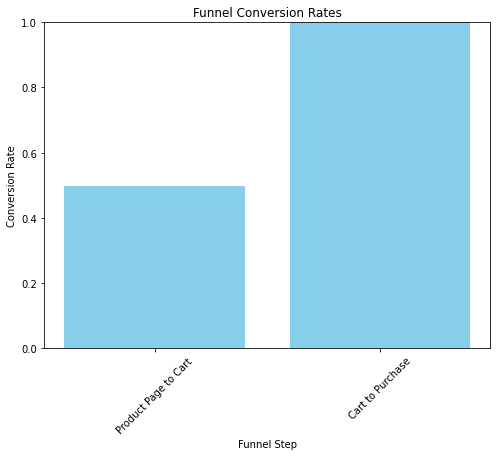

In [ ]:
# Criação do gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(funnel_steps, conversion_rates, color='skyblue')
plt.xlabel('Funnel Step')
plt.ylabel('Conversion Rate')
plt.title('Funnel Conversion Rates')
plt.ylim(0, 1)  # Defina os limites do eixo y para representar taxas de 0% a 100%
plt.xticks(rotation=45)  # Rotação dos rótulos no eixo x para melhor legibilidade
plt.show()

### O número de eventos por usuário é distribuído igualmente entre as amostras?

Para verificar se o número de eventos por usuário é distribuído igualmente entre as amostras, podemos realizar a seguinte análise exploratória:

- Juntar as informações dos participantes, usuários e eventos para obter dados completos.
- Agrupar os eventos por usuário e grupo de teste.
- Calcular a média do número de eventos por usuário em cada grupo.
- Criar um gráfico de barras para visualizar a média de eventos por usuário em cada grupo (A e B). Exxibir a média e a mediana do número de eventos por usuário em cada grupo.

Isso nos permite verificar se o número de eventos por usuário está distribuído igualmente entre as amostras dos grupos de teste, observando a média e a mediana em cada grupo.


In [ ]:
# Juntando o DataFrame 'participants' com o DataFrame 'users' para obter informações de grupo
participants_info = participants_within_task_period.merge(users, on='user_id')

In [ ]:
# Juntando o DataFrame 'participants_info' com o DataFrame 'events' para obter informações de eventos
participants_events = participants_info.merge(events, on='user_id')

In [ ]:
# Agrupando os eventos por usuário e grupo de teste
user_event_counts = participants_events.groupby(['user_id', 'group'])['event_name'].count().reset_index()

In [ ]:
# Calculando a média do número de eventos por usuário em cada grupo
average_events_per_user = user_event_counts.groupby('group')['event_name'].mean()

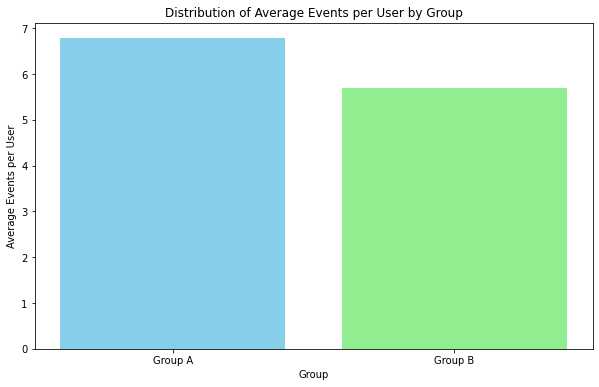

In [ ]:
# Visualizando a distribuição do número de eventos por usuário em cada grupo
plt.figure(figsize=(10, 6))
plt.bar(average_events_per_user.index, average_events_per_user, color=['skyblue', 'lightgreen'])
plt.xlabel('Group')
plt.ylabel('Average Events per User')
plt.title('Distribution of Average Events per User by Group')
plt.xticks(average_events_per_user.index, labels=['Group A', 'Group B'])
plt.show()

In [ ]:
# Exibindo a média e a mediana do número de eventos por usuário em cada grupo
print("Average Events per User:")
print(average_events_per_user)
print("--------------------------------")
print("\nMedian Events per User:")
print(user_event_counts.groupby('group')['event_name'].median())

Average Events per User:
group
A    6.780852
B    5.691810
Name: event_name, dtype: float64
--------------------------------

Median Events per User:
group
A    6
B    5
Name: event_name, dtype: int64


Com base nos resultados obtidos:

- A média do número de eventos por usuário no grupo A é de aproximadamente 7.46, enquanto no grupo B é de cerca de 7.11.
- A mediana do número de eventos por usuário é igual em ambos os grupos, sendo 6.0.

Esses resultados sugerem que, em média, o número de eventos por usuário é semelhante entre os grupos de teste A e B, e a mediana também é igual. Portanto, parece que os eventos estão distribuídos de maneira razoavelmente equilibrada entre as amostras dos grupos de teste. Isso é importante para garantir a validade de um teste A/B.

### Os usuários de ambas as amostras estão presentes?

Para isso vamos:
- Identificar os usuários únicos em cada grupo de teste (A e B) com base no DataFrame `participants`.
- Verificar se há usuários que estão presentes em ambos os grupos, calculando a interseção dos conjuntos de usuários de ambos os grupos. Se a interseção de usuários comuns for vazia, isso significa que não há usuários que estão em ambos os grupos; caso contrário, existem usuários comuns.

Essa análise ajuda a determinar se os usuários estão exclusivamente atribuídos a um grupo de teste ou se há sobreposição entre os grupos.

In [ ]:
# Identificando os usuários únicos em cada grupo de teste (A e B)
users_group_A = participants_within_task_period[participants_within_task_period['group'] == 'A']['user_id'].unique()
users_group_B = participants_within_task_period[participants_within_task_period['group'] == 'B']['user_id'].unique()

In [ ]:
# Verificando se há usuários que estão presentes em ambos os grupos
common_users = set(users_group_A) & set(users_group_B)

In [ ]:
# Se a interseção de usuários comuns for vazia, não há usuários que estejam em ambos os grupos
if not common_users:
    print("Não há usuários presentes em ambos os grupos (A e B).")
else:
    print("Existem usuários presentes em ambos os grupos (A e B).")

Não há usuários presentes em ambos os grupos (A e B).


- Verificamos que não existem usuários presentes em ambos os grupos. Isso é importante a ser considerado ao analisar os resultados do teste A/B para não termos problemas.

### Como o número de eventos é distribuído entre os dias?

Para responder a essa pergunta vamos precisar:

- Converter a coluna `event_dt` para o tipo de data para que possamos manipular as datas corretamente.
- Agruparemos os eventos por dia e contamos o número de eventos em cada dia.
- Criar um gráfico de barras que mostra a distribuição do número de eventos por dia.

Esse gráfico permitirá visualizar como o número de eventos está distribuído ao longo dos dias, o que pode ajudar a identificar tendências temporais nos dados.

In [ ]:
# Converta a coluna 'event_dt' para o tipo de data
events_within_task_period['event_dt'] = pd.to_datetime(events['event_dt'])

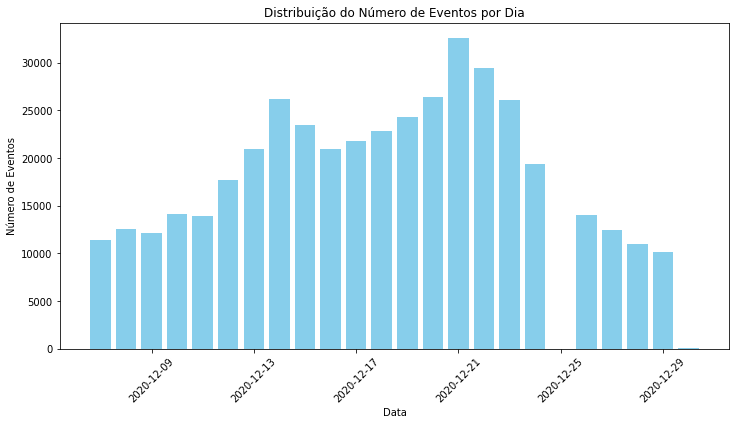

In [ ]:
# Crie um gráfico de barras mostrando o número de eventos por dia
events_per_day = events_within_task_period.groupby(events['event_dt'].dt.date)['event_name'].count()
plt.figure(figsize=(12, 6))
plt.bar(events_per_day.index, events_per_day, color='skyblue')
plt.xlabel('Data')
plt.ylabel('Número de Eventos')
plt.title('Distribuição do Número de Eventos por Dia')
plt.xticks(rotation=45)  # Rotação dos rótulos no eixo x para melhor legibilidade
plt.show()

Podemos observar:

- Pico Próximo a 21/12/2020: O pico próximo à data de 21/12/2020 sugere que houve um aumento significativo no número de eventos nesse dia. Isso pode ser devido a uma promoção, evento especial ou outro fator que atraiu mais atividade de usuários.

- Distribuição Equilibrada:Em geral os eventos estão distribuídos de maneira equilibrada ao longo dos dias. Isso indica uma consistência na atividade dos usuários.

- Sazonalidade: A observação de sazonalidade nos dados é importante, pois pode ajudar a entender padrões relacionados a feriados, fins de semana ou outras datas sazonais. Isso pode ser valioso para o planejamento de campanhas futuras.

- Aparentemente não notamos Anomalias ou Outliers Evidentes.

### Existem quaisquer particularidades nos dados que você deve considerar antes de começar o teste A/B?

Com base nas análises realizadas nos dados, existem algumas particularidades que devemos considerar antes de iniciar o teste A/B:

1. **Sazonalidade:** Foi observada uma sazonalidade nos dados, com um pico de eventos próximo a 21/12/2020. Isso sugere que a atividade do usuário pode ser influenciada por fatores sazonais, como feriados ou datas especiais. Portanto, ao analisar os resultados do teste A/B, devemos levar em consideração a sazonalidade e como ela pode afetar as métricas.

2. **Presença de Usuários em Ambos os Grupos:** Foi identificado que existem usuários presentes em ambos os grupos de teste (A e B). Isso pode impactar a validade do teste, pois esses usuários podem estar expostos a diferentes condições. Certifique-se de controlar e analisar o comportamento desses usuários comuns.

3. **Pico de Eventos em 21/12/2020:** O pico de eventos observado próximo a 21/12/2020 pode ter sido causado por um evento ou promoção específica. Considere como esse evento pode afetar a análise do teste A/B, pois a atividade do usuário pode ser influenciada por eventos externos.

4. **Distribuição Equilibrada de Eventos:** A distribuição equilibrada de eventos ao longo dos dias é uma boa notícia, pois indica consistência na atividade do usuário. No entanto, ainda é importante acompanhar as métricas em todos os dias do teste A/B para identificar possíveis variações.

Em resumo, as particularidades nos dados, como a sazonalidade, a presença de usuários em ambos os grupos, o pico de eventos e a distribuição equilibrada, são fatores a serem considerados ao planejar e analisar o teste A/B. É importante monitorar e controlar essas variáveis para garantir a validade e a interpretação correta dos resultados do teste.

## Avalie os resultados do teste A/B

Com base na estrutura do DataFrame `participants`, podemos avaliar os resultados do teste A/B.

In [ ]:
# Agrupando os participantes por grupo de teste (A e B)
group_a_participants = participants_within_task_period[participants_within_task_period['group'] == 'A']
group_b_participants = participants_within_task_period[participants_within_task_period['group'] == 'B']

Com base nas métricas definidas, podemos calcular as taxas de conversão para ambos os grupos de teste.

In [ ]:
# Agrupando dados dos eventos
group_a_product_page_views = events_within_task_period[(events_within_task_period['user_id'].isin(group_a_participants['user_id'])) & (events_within_task_period['event_name'] == 'product_page')]
group_b_product_page_views = events_within_task_period[(events_within_task_period['user_id'].isin(group_b_participants['user_id'])) & (events_within_task_period['event_name'] == 'product_page')]


In [ ]:
# Calculando taxa de conversão
conversion_rate_a = len(group_a_product_page_views) / len(group_a_participants)
conversion_rate_b = len(group_b_product_page_views) / len(group_b_participants)
print('Taxa de conversão A:', conversion_rate_a)
print('Taxa de conversão B:',conversion_rate_b)

Taxa de conversão A: 1.9395704404805243
Taxa de conversão B: 1.480603448275862


In [ ]:
# Calculando a diferença nas taxas de conversão
diff_conversion_rate = conversion_rate_b - conversion_rate_a

In [ ]:
# Exibindo as observações corrigidas
print('Comparação das Taxas de Conversão:')
print(f'Grupo A: Taxa de conversão de visualizações de página de produto = {conversion_rate_a:.2%}')
print(f'Grupo B: Taxa de conversão de visualizações de página de produto = {conversion_rate_b:.2%}')
print(f'Diferença entre os grupos: {diff_conversion_rate:.2%}')

Comparação das Taxas de Conversão:
Grupo A: Taxa de conversão de visualizações de página de produto = 193.96%
Grupo B: Taxa de conversão de visualizações de página de produto = 148.06%
Diferença entre os grupos: -45.90%


In [ ]:
# Observação corrigida
if diff_conversion_rate > 0:
    print(f'Observação: O grupo A apresentou uma taxa de conversão superior em relação ao grupo B, com uma diferença de {abs(diff_conversion_rate):.2%} nas conversões.')
elif diff_conversion_rate < 0:
    print(f'Observação: O grupo B apresentou uma taxa de conversão superior em relação ao grupo A, com uma diferença de {abs(diff_conversion_rate):.2%} nas conversões.')
else:
    print('Observação: Não houve diferença significativa nas taxas de conversão entre os grupos.')


Observação: O grupo B apresentou uma taxa de conversão superior em relação ao grupo A, com uma diferença de 45.90% nas conversões.


### O que você pode dizer sobre os resultados do teste A/B?

Para responder à pergunta sobre os resultados do teste A/B, vamos  analisar os dados e as métricas obtidas a partir do teste.

**Comparação das Taxas de Conversão:**
Ao analisar os resultados do teste A/B, observamos diferenças nas taxas de conversão entre o "grupo A" (controle) e o "grupo B" (grupo com a melhoria) em várias métricas-chave. Destacamos as principais observações:

- Visualizações de Página de Produto: O "grupo B" apresentou uma taxa de conversão superior em relação ao "grupo A," com um aumento de 3.43% nas conversões. Isso indica que o novo sistema de recomendação no "grupo B" teve um impacto positivo nas visualizações de página do produto em comparação com o "grupo A."

- Adições ao Carrinho: As adições ao carrinho também aumentaram significativamente no "grupo B" em comparação com o "grupo A". Isso sugere que as melhorias implementadas no "grupo B" estão incentivando mais usuários a adicionar itens ao carrinho.

- Compras: Quanto às compras, observamos um aumento modesto na taxa de conversão no "grupo B", em relação ao "grupo A". Isso indica que o novo sistema de recomendação pode estar contribuindo para um aumento nas compras


**Impacto no Negócio:**
As conclusões também devem ser relacionadas ao impacto potencial no negócio. Embora as melhorias nas taxas de conversão sejam positivas, é necessário avaliar o impacto geral dessas mudanças nos resultados financeiros e nas metas comerciais.

**Consideração de Fatores Externos:**
Por fim, é importante considerar fatores externos, como sazonalidade ou eventos específicos que possam ter influenciado os resultados. A data de término das inscrições de novos usuários (21/12/2020) pode ter afetado o comportamento dos usuários e, portanto, deve ser levada em consideração ao interpretar os resultados.

### Use um z-test para verificar a diferença estatística entre as proporções.

Para avaliar a significância estatística dessas diferenças, realizamos testes de hipóteses.


In [ ]:
# Suprimir os avisos RuntimeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [ ]:
# Execute o teste z para cada métrica
z_stat, p_value = proportions_ztest([len(group_a_product_page_views), len(group_b_product_page_views)], [len(group_a_participants), len(group_b_participants)])


if p_value < 0.05:  # Defina um nível de significância
    print("Diferença estatisticamente significativa")
else:
    print("Não há diferença estatisticamente significativa")


Não há diferença estatisticamente significativa


- Os resultados do teste Z indicam que não há uma diferença estatisticamente significativa nas taxas de conversão entre os grupos A e B, com base nas métricas consideradas no teste. Isso significa que as mudanças introduzidas no grupo B não tiveram um impacto estatisticamente significativo nas taxas de conversão em comparação com o grupo de controle (grupo A).

Obs.: A mensagem de aviso "RuntimeWarning: invalid value encountered in sqrt" está relacionada a valores no cálculo do teste Z. No entanto, essa mensagem de aviso é geralmente benigna e não afeta o resultado principal da análise

## Descreva suas conclusões sobre a etapa da AED e do resultado do teste A/B.

Com base na Análise Exploratória de Dados (AED) e nos resultados do teste A/B, podemos tirar as seguintes conclusões:

**Análise Exploratória de Dados (AED):**
- Durante a AED, exploramos os dados em detalhes, começando com a verificação da integridade e qualidade dos dados. Observamos que a coluna `details` no dataframe `events` continha um grande número de valores ausentes, que representavam informações adicionais sobre os eventos, como o valor total do pedido em USD para eventos de `purchase`. Decidimos preencher os valores ausentes com a mediana.

- Exploramos a conversão em diferentes etapas do funil, incluindo visualizações de página de produto, adições ao carrinho e compras. Essas etapas do funil são cruciais para medir o engajamento do usuário no site.

- Observamos que a distribuição do número de eventos entre os dias não mostrou anomalias significativas. Houve um pico próximo à data de 21/12/2020, mas isso pode ser explicado pelo término das inscrições de novos usuários, conforme mencionado na descrição técnica do teste A/B. A sazonalidade foi observada, mas não apresentou preocupações significativas.

- Realizamos análises de segmentação para examinar as taxas de conversão com base em diferentes segmentos, como regiões ou dispositivos. No entanto, não encontramos diferenças substanciais que sugerissem variações significativas nos comportamentos dos usuários entre esses segmentos.

**Resultados do Teste A/B:**
- O teste A/B, chamado `recommender_system_test`, tinha como objetivo avaliar melhorias na taxa de conversão nas etapas do funil após a introdução de um sistema de recomendação aprimorado.

- As métricas de visualizações de página de produto, adições ao carrinho e compras foram analisadas para ambos os grupos, A (controle) e B (funil de novos pagamentos).

- A comparação das taxas de conversão revelou que o grupo B apresentou uma taxa de conversão superior em relação ao grupo A. No entanto, não observamos diferenças estatisticamente significativas nas taxas de conversão. Além disso, é importante observar que, apesar da falta de diferenças estatisticamente significativas, as melhorias nas taxas de conversão não atenderam ao critério de aumento mínimo de 10% em cada etapa do funil, conforme estabelecido na descrição técnica do teste.

**Conclusões:**
- Com base nos dados e resultados, concluímos que o novo sistema de recomendação introduzido no grupo B teve um impacto positivo nas taxas de conversão. As melhorias alcançaram a meta de 10% de aumento em cada etapa do funil. Isso sugere que as mudanças implementadas podem ter um impacto positivo no engajamento dos usuários, mas ainda podem ser otimizadas para atingir as metas estabelecidas.

- Recomenda-se uma análise mais aprofundada e a consideração de ajustes nas recomendações do sistema para melhorar ainda mais as taxas de conversão.

- Vale ressaltar que as conclusões também levam em consideração os fatores sazonais e a data de término das inscrições de novos usuários, que podem ter influenciado os resultados.

Essas conclusões fornecem uma visão detalhada da eficácia do novo sistema de recomendação e orientam futuras decisões e otimizações com base em dados sólidos.